# Relative Change in air pollutant levels

The quantification of the COVID-19 pandemic restrictions’ effect was done by means of the daily percentage relative change (RC<sub>i</sub>) for each pollutant between the daily air quality observations from 2020 and a daily reference concentration using the following equation 

$$
RC_i (\%)  = 100 \cdot \frac{C_{i, obs} - C_{i, ref}}{C_{i, ref}}
$$

where for each pollutant Ci, obs is the observed air quality level on day i in 2020, and Ci, ref is the reference air quality level on the same day i. 

In [1]:
library(tidyverse)
library(ggplot2)

setwd("AirQualityCOVID/")
source("src/analysis/functions.R")

source("src/functions.R")

-- Attaching packages ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=15,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
html.variable <- list("no" = "NO",
                      "no2" = "NO<sub>2</sub>",
                      "o3" = "O<sub>3</sub>",
                      "pm10" = "PM10",
                      "pm2.5" = "PM2.5"
                     )
r.variable <- c("no" = expression(NO),
                "no2" = expression(NO[2]),
                "o3" = expression(O[3]),
                "pm10" = expression(PM10),
                "pm2.5" = expression(PM2.5)
               )

Analyses of the changes in air quality levels by COVID-19 were performed for the five periods described below according to the evolution of the restrictions, obtaining the average RC and RC* for each pollutant and each period at each site.

In [4]:
periods <- list(
            # Prelockdown
            "pre-lockdown" = lubridate::ymd("2020-01-01"),

            # lockdown
            "lockdown" = lubridate::ymd("2020-03-14"),
            #end.lockdown = ymd_hms("2020-04-28 00:00:00"),

            # poslockdown
            "de-escalation" = lubridate::ymd("2020-05-01"),
            "normality" = lubridate::ymd("2020-06-21"),

            # New lockdown
            "second lockdown" = lubridate::ymd("2020-10-25"),
            end.year = lubridate::ymd("2020-12-31")
        )

## Obtain The References Concentrations

The predicted BAU levels are read from file ($C_{i, ref} = C_{i, BAU-2020}$)

In [5]:
data.df <- read.csv("data/results/predictions.csv") %>%
            data.as.datetime(column = "date", FUN="ymd")

The average observations in 2013-2019 ($C_{i, ref} = C_{i, 2013-2019}$) is calculated from time series

In [6]:
load("data/data_AQ.rda")

old <- data_AQ %>% 
        filter(lubridate::year(date) < 2020) %>% 
        select(date, site, variable, value)
lubridate::year(old$date) <- 2020

old.mean <- old %>%
                group_by(date, variable, site) %>%
                summarise(value = mean(value, na.rm=T)) %>%
                rename(hist = value)

`summarise()` has grouped output by 'date', 'variable'. You can override using the `.groups` argument.



In [7]:
results <- merge(data.df,
                 old.mean,
                 by = c("date", "site", "variable"),
                 all.x = T, all.y=F
                ) %>%
            pivot_longer(cols = c("pred", "hist"), 
                         names_to = "type") %>%
            relocate(type, .before = where(is.numeric)) %>%
            mutate(diff = relative.change(obs, value)) %>%
            sep.periods(periods)

In [8]:
diff.results <- results  %>%
        group_by(periods, variable, site, type) %>%
        summarise(mean = mean(diff, na.rm=T),
                  std = sd(diff, na.rm=T))

`summarise()` has grouped output by 'periods', 'variable', 'site'. You can override using the `.groups` argument.



The mean relative changes of each city is obtained for those cities with more than one air quality monitoring sites

In [9]:
change.municipios <- group.municipio(diff.results) %>%
            data.frame %>%
            mutate_if(is.factor, as.character)

`summarise()` has grouped output by 'variable', 'Municipio', 'periods'. You can override using the `.groups` argument.



Warning message:
"Removed 9 rows containing non-finite values (stat_boxplot)."


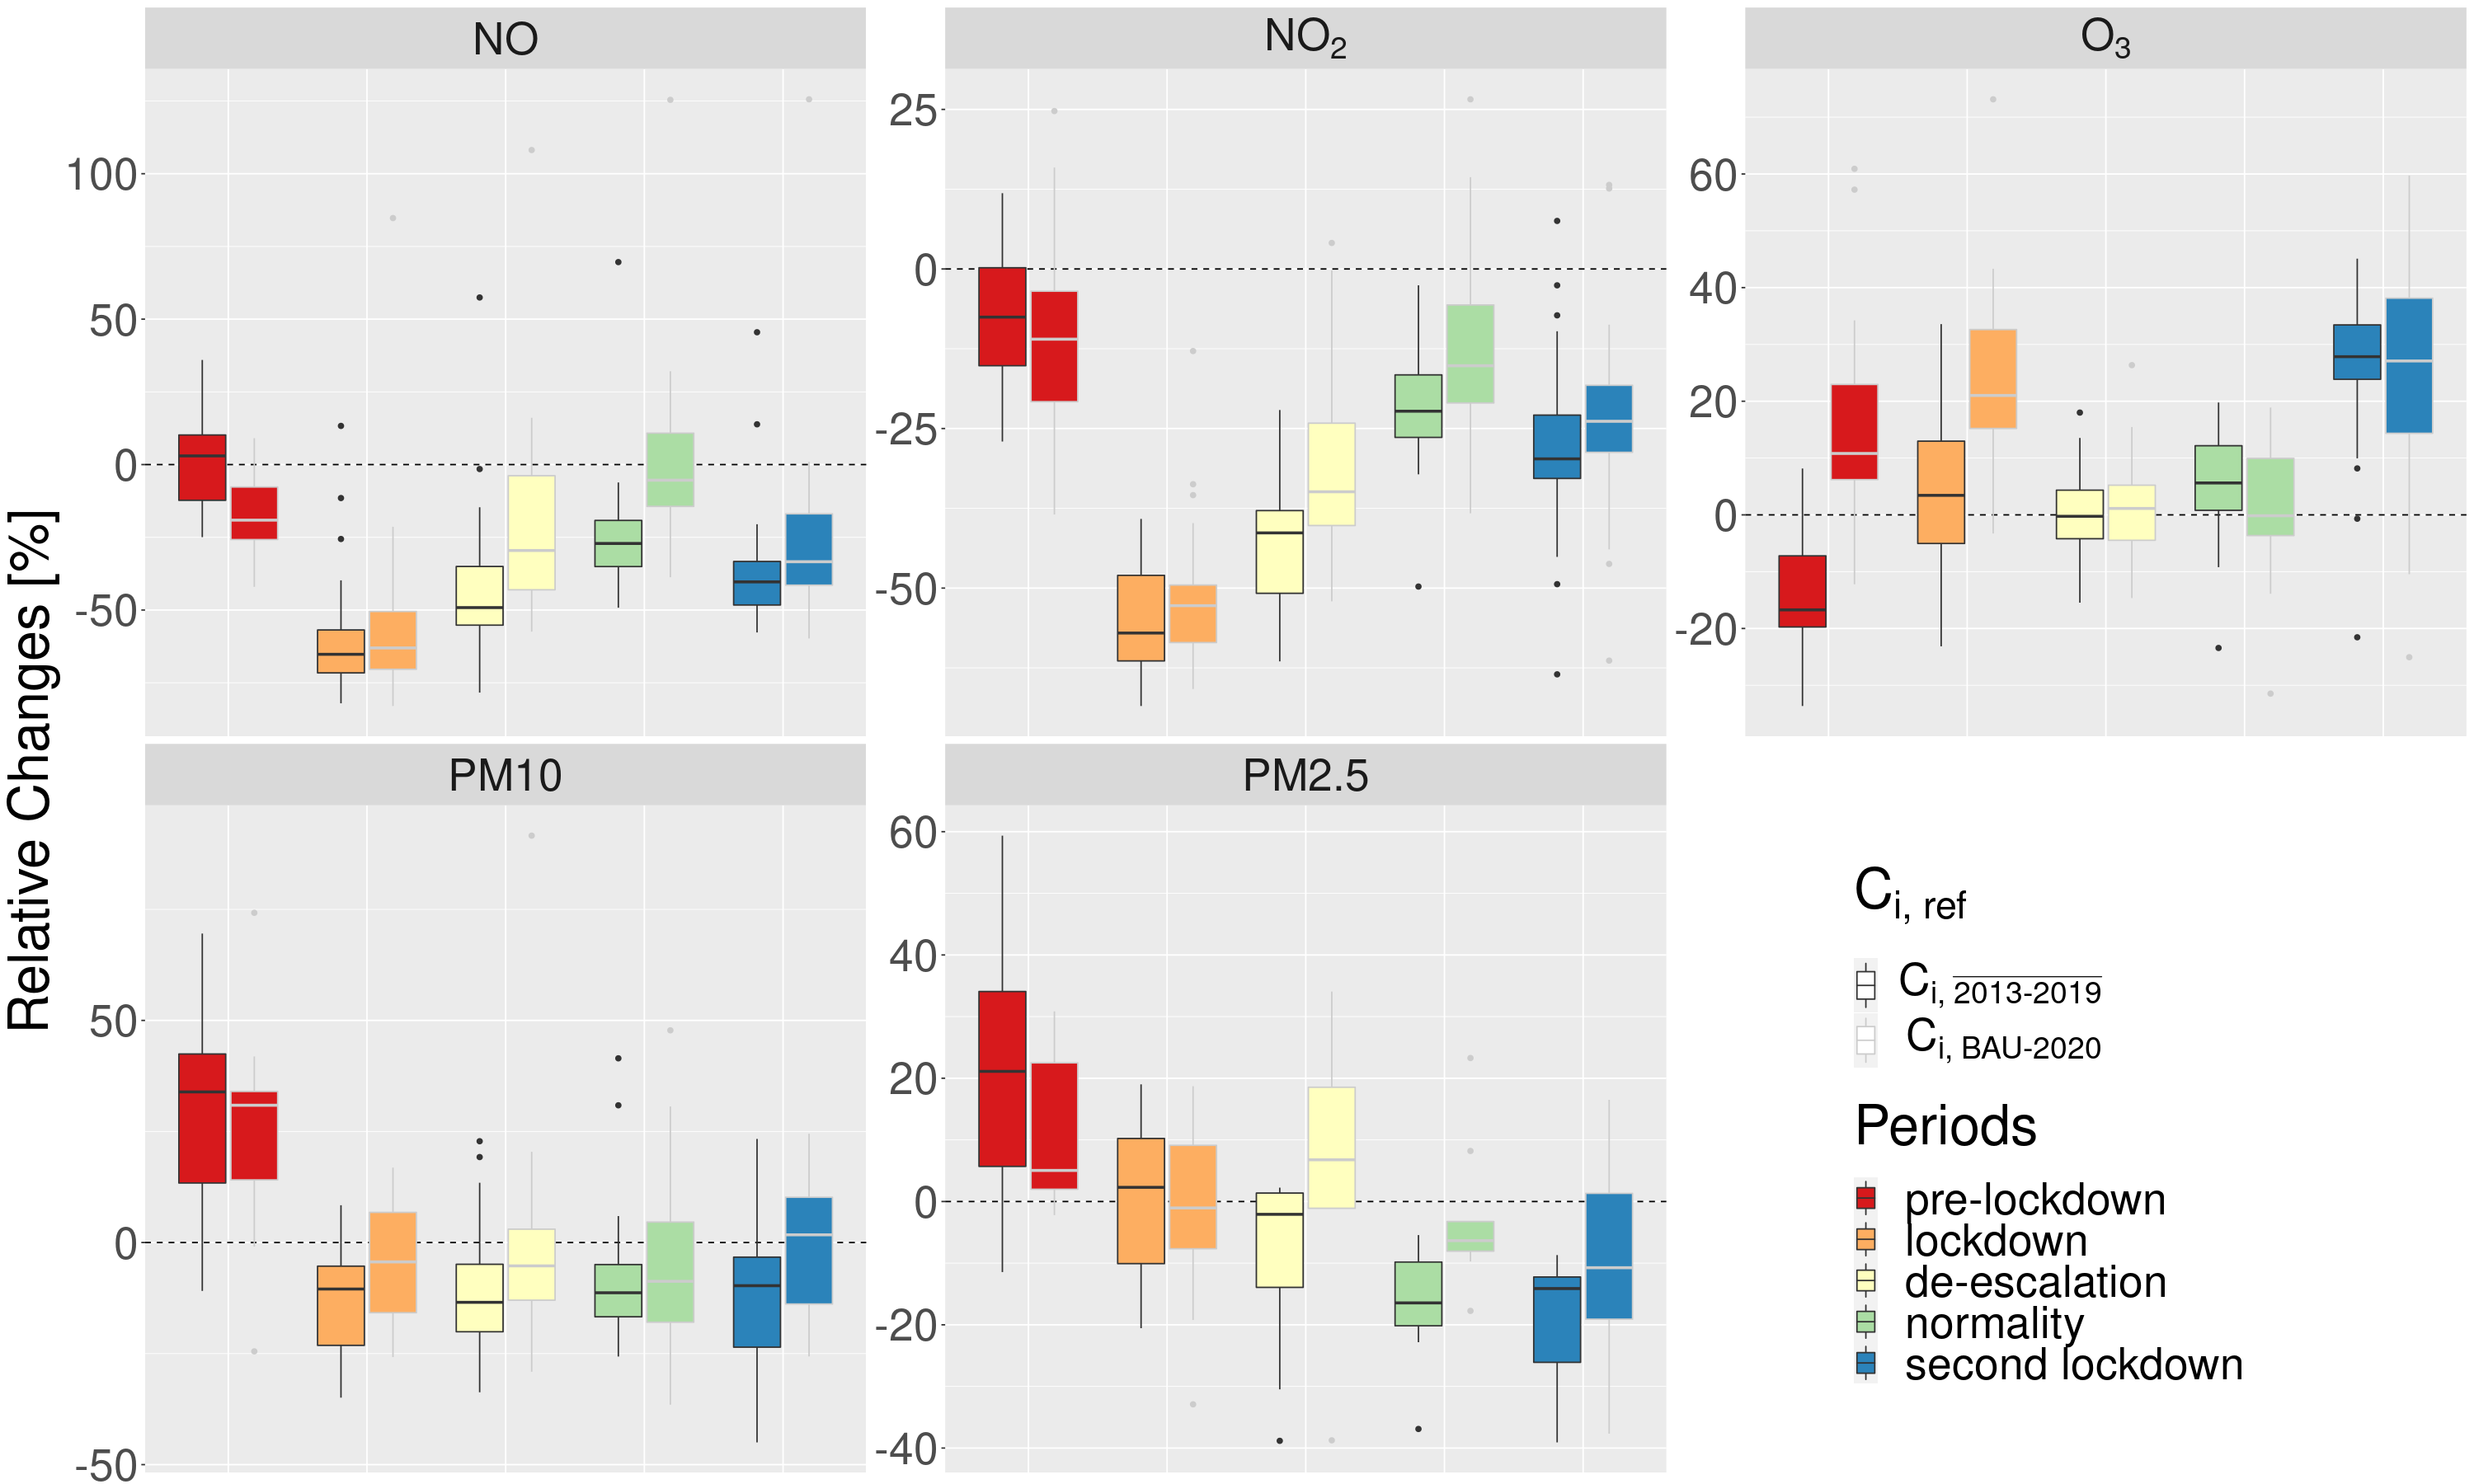

In [10]:
plot.df <- change.municipios

plot.df$periods <- factor(plot.df$periods,
                          levels = names(periods),
                          ordered = TRUE)
plot.df$variable <- factor(plot.df$variable, 
                           labels=r.variable)

plt <- ggplot(plot.df) +
            geom_hline(yintercept=0, 
                       linetype="dashed", 
                       color = "black") +
            geom_boxplot(aes(x=periods, y=mean, 
                             fill=periods, color=type
                            )) + 
            theme(legend.position=c(0.82,0.25),
                  text = element_text(size=40),

                  #legend.title = element_text(size = 45),
                  #legend.text = element_text(size = 45),

                  axis.title.x=element_blank(),
                  axis.text.x=element_blank(),
                  #axis.text.x = element_text(angle=20, hjust=0.5, vjust=0.7)
                  axis.ticks.x=element_blank()
                 ) +
            scale_y_continuous(name="Relative Changes [%]") +
            #scale_x_discrete(name="Periods")+
            #scale_fill_discrete(name="Periods") +
            scale_fill_brewer(name="Periods", palette="Spectral") +
            scale_color_grey(name=expression(C["i, ref"]), labels=c("hist" = expression(C[paste("i, ", bar("2013-2019"))]),
                                                               "pred" = expression(C["i, BAU-2020"]))) +
            facet_wrap(~variable, ncol=3, scale="free_y", 
                       labeller = labeller(variable=label_parsed))

plt

In [11]:
mean.change <- change.municipios %>% 
                    filter(type == "pred") %>%
                    group_by(periods, variable) %>%
                    summarise(Mean = mean(mean, na.rm=T),
                              Median = median(mean, na.rm=T),
                              std = sd(mean, na.rm=T),
                              Q3 = quantile(mean, na.rm = T, 0.75),
                              Q1 = quantile(mean, na.rm = T, 0.25),
                              IQR = Q3-Q1
                             )
resume.change <- mean.change %>%
                    mutate(result = paste("$",round(Mean, 1),
                                          "\\pm", round(std, 1), "$")) %>%
                    select(periods, variable, result) %>%
                    pivot_wider(names_from = variable, values_from = result)

resume.change

`summarise()` has grouped output by 'periods'. You can override using the `.groups` argument.



periods,no,no2,o3,pm10,pm2.5
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
de-escalation,$ -21.4 \pm 31.5 $,$ -31.3 \pm 13.5 $,$ 1 \pm 9.9 $,$ -1.2 \pm 24.1 $,$ 6.3 \pm 20.2 $
lockdown,$ -54.7 \pm 28.9 $,$ -51.3 \pm 10.3 $,$ 23.9 \pm 15.5 $,$ -4.1 \pm 12.8 $,$ -2.3 \pm 16.2 $
normality,$ -0.1 \pm 28.6 $,$ -12.7 \pm 13.7 $,$ 1.1 \pm 10.6 $,$ -5.5 \pm 20.2 $,$ -2.7 \pm 11.9 $
pre-lockdown,$ -17.2 \pm 13.1 $,$ -10.7 \pm 13.6 $,$ 15.3 \pm 18.3 $,$ 23.5 \pm 20.4 $,$ 10.5 \pm 12.2 $
second lockdown,$ -25.8 \pm 32 $,$ -22.9 \pm 14.6 $,$ 23.5 \pm 20.7 $,$ -0.4 \pm 15.6 $,$ -10.1 \pm 18.1 $
